In [1]:
import sys
import gymnasium as gym
sys.modules["gym"] = gym

In [2]:
import gnwrapper

In [3]:
import os
import numpy as np
import torch

In [4]:
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import EvalCallback

In [5]:
env_id = "MountainCarContinuous-v0"
NUM_CPU = 8  # Number of processes to use

In [6]:
# Parallel environments
train_env = make_vec_env(env_id, n_envs=NUM_CPU)
eval_callback = EvalCallback(train_env, best_model_save_path="./logs/",
                             log_path="./logs/", eval_freq=500,
                             deterministic=True, render=False)

model = PPO("MlpPolicy", train_env,
            verbose=1, 
            gae_lambda=0.98,
            gamma=0.99,
            n_epochs=4,
            n_steps=NUM_CPU,
            tensorboard_log="./logs/ppo_MountainCar_tensorboard/")
model.learn(total_timesteps=1_000, callback=eval_callback)
model.save("ppo_MountainCar")

del model # remove to demonstrate saving and loading

Using cpu device
Logging to ./logs/ppo_MountainCar_tensorboard/PPO_2
-----------------------------
| time/              |      |
|    fps             | 2488 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 64   |
-----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 2302          |
|    iterations           | 2             |
|    time_elapsed         | 0             |
|    total_timesteps      | 128           |
| train/                  |               |
|    approx_kl            | 1.8340535e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.42         |
|    explained_variance   | 0.000313      |
|    learning_rate        | 0.0003        |
|    loss                 | 0.0184        |
|    n_updates            | 4             |
|    policy_gradient_loss | -0.000313     |
|    std         

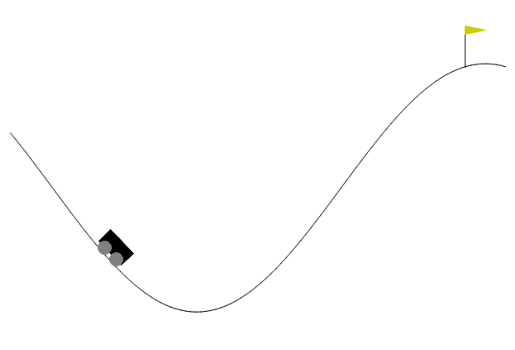

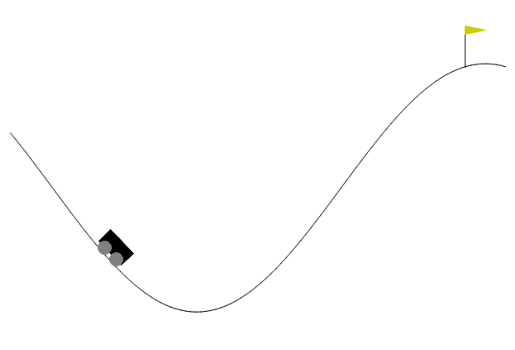

In [11]:
# test_env = gym.make(env_id, render_mode="human")
# test_env = gnwrapper.Animation(test_env)
# test_env = DummyVecEnv([lambda: test_env])

test_env = make_vec_env(env_id,
                        env_kwargs=dict(
                            render_mode="rgb_array"
                        ),
                        wrapper_class=gnwrapper.Animation,
                        n_envs=1)

model = PPO.load("ppo_MountainCar")

obs = test_env.reset()

for _ in range(500):
    action, _states = model.predict(obs)
    obs, rewards, dones, info = test_env.step(action)
    test_env.render()
    
    if dones:
        break

test_env.close()
    

In [9]:
test_env = make_vec_env(env_id,
                        env_kwargs=dict(
                            render_mode="human"
                        ),
                        n_envs=1)

model = PPO.load("ppo_MountainCar")

obs = test_env.reset()

for _ in range(100):
    action, _states = model.predict(obs)
    obs, rewards, dones, info = test_env.step(action)
    
    if dones:
        break

test_env.close()
    